## Analysis of IMDB data with scikit-learn & custom algorithms

### Logistic Regression

#### IMDB data analysis




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report


C:\Users\stamc\AppData\Local\Temp\ipykernel_28720\2756478788.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd



We define the **hyperparameters** to be used in reconstructing the given data and draw these data from the IMDB database, ignoring the most frequently n used words  and the least frequently k used words . (hyperparameters).

In [2]:
m = 2500  
n = 200    
k = 20     
infogain = False
g = 800 



We draw the data from the IMDB database, leaving behind the n most frequently used words and the k least frequently used words.

(Its the hyperparameters that we previously defined)

In [3]:

(x_train_imdb, y_train_imdb), (x_test_imdb, y_test_imdb) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)

word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train_imdb])
x_test_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test_imdb])


### Creation of binary data

We convert the extracted data into binary vectors. Possible values ​​are 0 and 1. A value of 1 implies that the corresponding word is contained in the text, while a value of 0 implies that it is not



In [4]:
binary_vectorizer = CountVectorizer(binary=True)
x_train_imdb_binary = binary_vectorizer.fit_transform(x_train_imdb)
x_test_imdb_binary = binary_vectorizer.transform(x_test_imdb)
print(
    'Vocabulary size:', len(binary_vectorizer.vocabulary_)
)

x_train_imdb_binary = x_train_imdb_binary.toarray()
x_test_imdb_binary = x_test_imdb_binary.toarray()


Vocabulary size: 2240



X is an array of vectors (reviews), with each vector representing words.
Y is a vector of labels (0 or 1) where 0 is a negative evaluation and 1 a positive one.

$$X = \begin{bmatrix} \vec{x_{1}} \\ \vdots \\ \vec{x_{m}} \end{bmatrix}\, \, \, 
y = \begin{bmatrix} y_{1} \\ \vdots \\ y_{m} \end{bmatrix}$$

### Information Gain
It's code from the labs. Returns the g words with the highest information gain from the dataset.

In [5]:
from math import log 

if  infogain:
  def IG(class_, feature):
    classes = set(class_)

    Hc = 0
    for c in classes:
      pc = list(class_).count(c)/len(class_)
      Hc += - pc * log(pc, 2)
    feature_values = set(feature)

    Hc_feature = 0 # Αρχικοποίηση της εντροπίας του χαρακτηριστικού Hc_feature.
    for feat in feature_values:
      
      # Υπολογισμός του P(X=x)
      pf = list(feature).count(feat)/len(feature)
      indices = [i for i in range(len(feature)) if feature[i] == feat]
      clasess_of_feat = [class_[i] for i in indices]
      for c in classes:
          # Υπολογισμός του P(C=c|X=x)
          pcf = clasess_of_feat.count(c)/len(clasess_of_feat)
          if pcf != 0: 
              # Υπολογισμός του - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
              temp_H = - pf * pcf * log(pcf, 2)
              #sum for all values of C (class) and X (values of specific feature)
              Hc_feature += temp_H
    # Υπολογισμός του information gain.
    ig = Hc - Hc_feature
    return ig

  # Επιλογή των g πιο σημαντικών χαρακτηριστικών.
  ig = [(i, IG(y_train_imdb, x_train_imdb_binary[:, i])) for i in range(len(x_train_imdb_binary[0]))]
  ig.sort(key=lambda x: x[1], reverse=True)
  ig = ig[:g]
  # Προσαρμογή των δεδομένων εκπαίδευσης και ελέγχου.
  x_train_binary = x_train_imdb_binary[:, [i[0] for i in ig]]
  x_test_binary = x_test_imdb_binary[:, [i[0] for i in ig]]

### Implementation of the Logistic Regression classifier.
##### The most ideal model parameters are 0.1 for lambda_value, 1000 for max_iter and 0.001 for eta. In this implementation we use stochastic gradient ascent, we try to reach global maxima by moving slowly upwards thereby maximizing the cost function to train our model. A prerequisite to train our model is to apply  the gradien  to the weights multiplied by the eta value. The main idea of ​​this algorithm is to predict the output with the help of sigmoid function and threshold.

In [6]:
class LogisticRegression:
    def __init__(self, lambda_value = 0.01, max_iter = 1000,eta=0.001):
        self.lambda_value = lambda_value
        self.max_iter = max_iter
        self.weights = None
        self.regularization = 0
        self.eta = eta

   
         

    def fit(self, X, y):
        samples = X.shape[0]
        features = X.shape[1]
        self.weights = np.zeros(features)

        for t in range(self.max_iter):
            linear = np.dot(X, self.weights) 
            y_pred = self.sigmoid(linear)

            gradient_ascent = np.mean((y-y_pred)*X.T, axis=1)-self.lambda_value*sum(self.weights**2)
            
            self.weights += self.eta * gradient_ascent
                  
            
           
    def predict(self, X):
        linear = np.dot(X, self.weights)
        y_pred = self.sigmoid(linear)
        y_pred_classes = [1 if i>0.5 else 0 for i in y_pred]
        return y_pred_classes
    
    def sigmoid(self, t):
        return 1 / (1 + np.exp(-t))

### Results of Logistic Regression classifier.

The Logistic Regression classifier is  being tested on the test data and the results are shown in the table below. A comparison is also made between the prediction results of the training data and the test data.

In [8]:
from visualizations import *

log = LogisticRegression()

log.fit(x_train_imdb_binary, y_train_imdb)
print(classification_report(y_test_imdb,log.predict(x_test_imdb_binary)))

data = classification_data(LogisticRegression(), x_train_imdb_binary, y_train_imdb, x_test_imdb_binary, y_test_imdb, 5)
data_table = classification_table(data,x_train_imdb_binary)
ipd.display(data_table)

              precision    recall  f1-score   support

           0       0.81      0.86      0.83     12500
           1       0.85      0.80      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.84,0.81,0.79,0.77,0.92,0.90,0.85,0.83
10000,0.84,0.83,0.82,0.81,0.87,0.85,0.85,0.83
15000,0.84,0.83,0.84,0.83,0.84,0.83,0.84,0.83
20000,0.84,0.83,0.83,0.83,0.85,0.83,0.84,0.83
25000,0.83,0.83,0.85,0.85,0.81,0.80,0.83,0.82


###

### Learning Curve of Logistic Regression

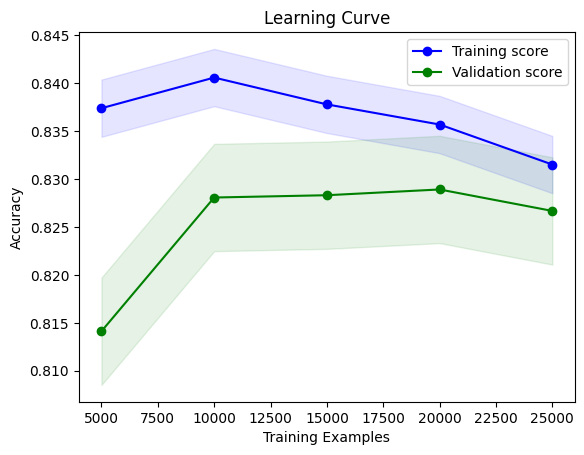

In [9]:
plot_learning_curve(data)

In [ ]:
print(data)

{'estimator': 'LogisticRegression', 'split_size': 5000, 'splits': 5, 'test_predictions': [0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0

### Optimization algorithm

 In this part we train our model for candidate values ​​of eta , lambda_value and max_iter. Based on the accuracy score we choose the optimal combination of thease values. This search is done on the same search and evaluation data.


In [ ]:
from visualizations import *


Eta=[0.01, 0.001]
L=[1, 0.1, 0.01, 0.001]
iter=[1000,100,50]
maxAccuracy = -float('inf')

from sklearn.model_selection import train_test_split
X_train, X_dev, y_train_t, y_dev = train_test_split(x_train_imdb_binary, y_train_imdb,test_size=0.2)

for h in Eta:
    for l in L:
        for i in iter:
            log.eta=h
            log.lambda_value=l
            log.max_iter=i
            log.fit(X_train,y_train_t)
            c_accuracy=accuracy_score(y_dev,log.predict(X_dev))
            if(c_accuracy>maxAccuracy):
                maxAccuracy = c_accuracy
                bestl=l
                besth=h
                bestIter=i

print(bestl)
print(besth)
print(bestIter)

C:\Users\stamc\AppData\Local\Temp\ipykernel_31636\913407241.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))
C:\Users\stamc\AppData\Local\Temp\ipykernel_31636\913407241.py:21: RuntimeWarning: overflow encountered in square
  gradient_ascent = np.mean((y-y_pred)*X.T, axis=1)-self.lambda_value*sum(self.weights**2)
C:\Users\stamc\AppData\Local\Temp\ipykernel_31636\913407241.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))
C:\Users\stamc\AppData\Local\Temp\ipykernel_31636\913407241.py:21: RuntimeWarning: overflow encountered in square
  gradient_ascent = np.mean((y-y_pred)*X.T, axis=1)-self.lambda_value*sum(self.weights**2)
C:\Users\stamc\AppData\Local\Temp\ipykernel_31636\913407241.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))
C:\Users\stamc\AppData\Local\Temp\ipykernel_31636\913407241.py:21: RuntimeWarning: overflow encountered in square
  gradient_ascent = np.mean((y-y_pred)*X.T, axis=1)-s

0.001
0.01
1000


## Charts of algorithm analysis metrics

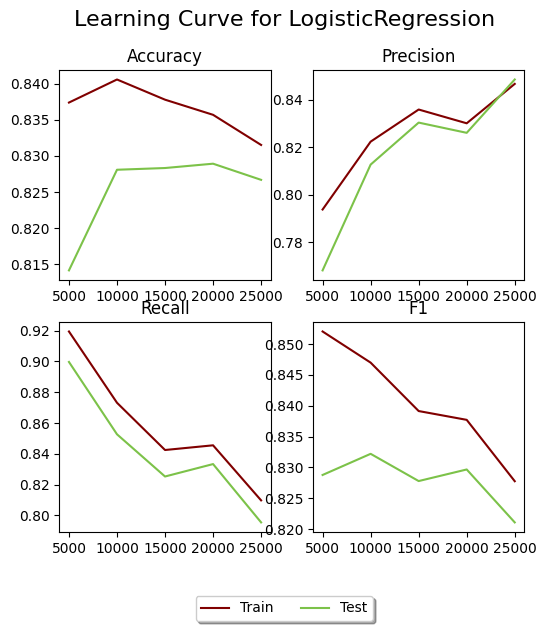

In [ ]:
plot = classification_plots(data)



### Results of sklearn LogisticRegression

In [6]:
import warnings
from visualizations import *
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression

logistic_data = classification_data(LogisticRegression(), x_train_imdb_binary, y_train_imdb, x_test_imdb_binary, y_test_imdb, 5)
logistic_data['estimator'] = 'SKLogisticRegression'
logistic_table = classification_table(logistic_data,x_train_imdb_binary)
ipd.display(logistic_table)

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.99,0.82,0.99,0.82,0.99,0.82,0.99,0.82
10000,0.95,0.83,0.94,0.83,0.95,0.84,0.95,0.83
15000,0.92,0.84,0.92,0.84,0.93,0.85,0.92,0.84
20000,0.91,0.85,0.91,0.84,0.92,0.85,0.91,0.85
25000,0.90,0.85,0.90,0.85,0.91,0.86,0.90,0.85


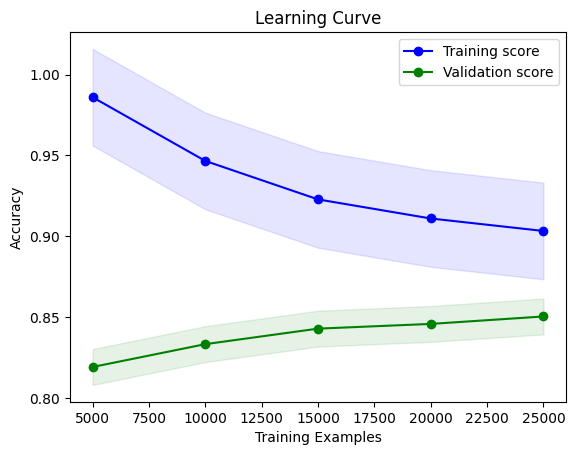

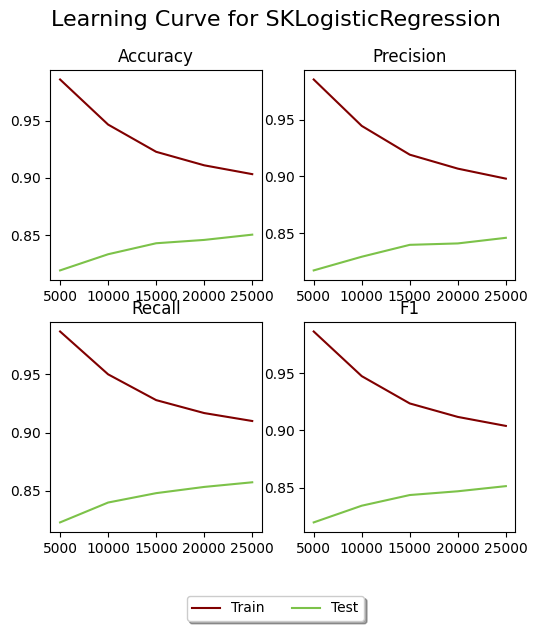

In [8]:
plot_learning_curve(logistic_data)

l=classification_plots(logistic_data)


####  Difference table between SK Learn's LogisticRegression and our implementation

In [ ]:

difference_table = abs(logistic_table - data_table)
difference_table = difference_table.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=data['estimator'], estimator_2=logistic_data['estimator']))
ipd.display(difference_table)

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.150000,0.010000,0.200000,0.050000,0.070000,0.080000,0.140000,0.010000
10000,0.110000,0.000000,0.120000,0.020000,0.080000,0.010000,0.100000,0.000000
15000,0.080000,0.010000,0.080000,0.010000,0.090000,0.020000,0.080000,0.010000
20000,0.070000,0.020000,0.080000,0.010000,0.070000,0.020000,0.070000,0.020000
25000,0.070000,0.020000,0.050000,0.000000,0.100000,0.060000,0.070000,0.030000



####  Difference charts  between SK Learn's LogisticRegression and our implementation

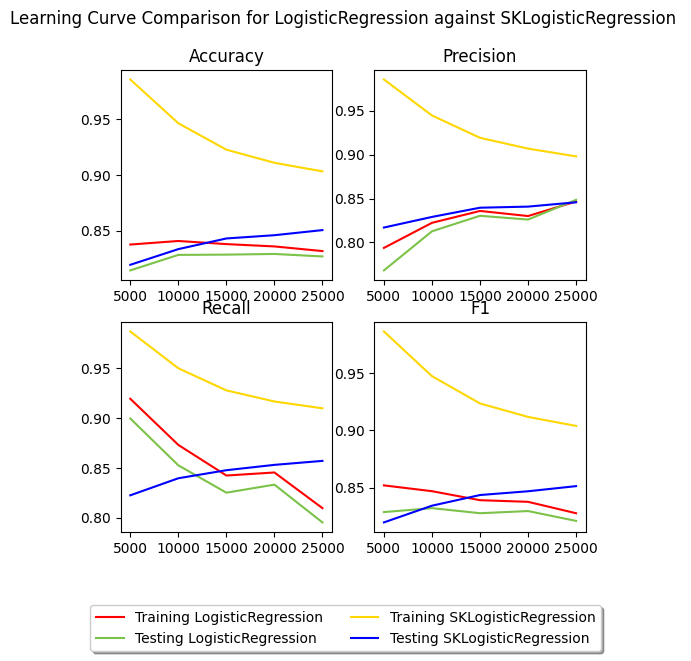

In [ ]:
plot = classification_plots_compare(data,logistic_data)

### Results of sklearn SGDClassifier

In [10]:
from sklearn.linear_model import SGDClassifier


linear_data = classification_data(SGDClassifier(), x_train_imdb_binary, y_train_imdb, x_test_imdb_binary, y_test_imdb, 5)
linear_data['estimator'] = 'SGDClassifier'
linear_table = classification_table(linear_data, x_train_imdb_binary)
ipd.display(linear_table)

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,1.00,0.79,1.00,0.80,1.00,0.79,1.00,0.79
10000,0.96,0.82,0.96,0.83,0.95,0.80,0.96,0.82
15000,0.93,0.84,0.93,0.84,0.93,0.83,0.93,0.84
20000,0.92,0.84,0.92,0.85,0.91,0.83,0.92,0.84
25000,0.91,0.85,0.90,0.84,0.92,0.86,0.91,0.85


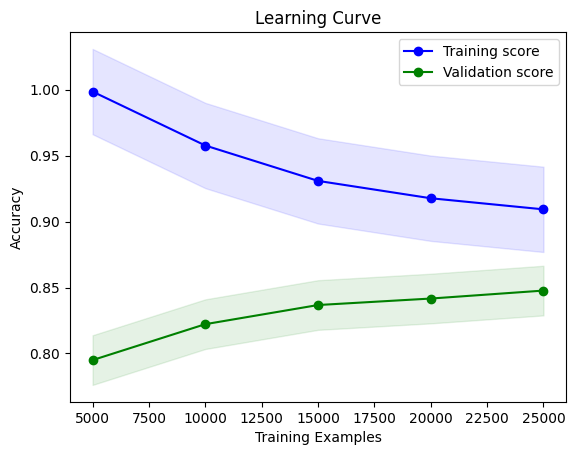

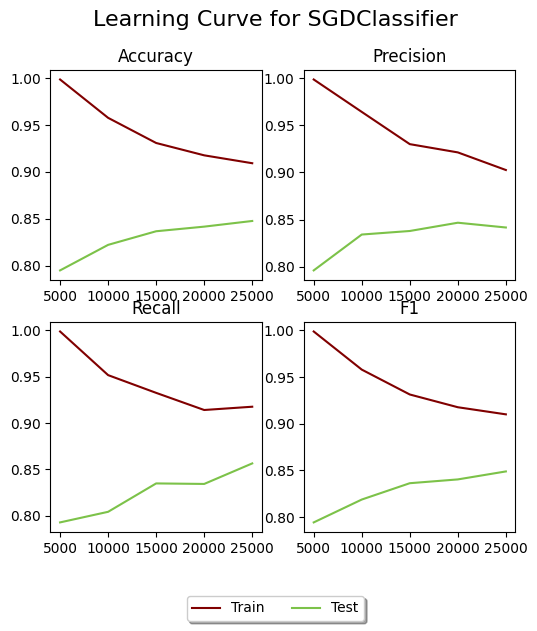

In [11]:
plot_learning_curve(linear_data)

p = classification_plots(linear_data)

###  Difference table  between LogisticRegression and SGDClassifier

In [ ]:

difference_table = abs(linear_table - data_table)
difference_table = difference_table.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=data['estimator'], estimator_2=linear_data['estimator']))
ipd.display(difference_table)

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.180000,0.010000,0.240000,0.080000,0.050000,0.140000,0.160000,0.020000
10000,0.130000,0.000000,0.170000,0.020000,0.080000,0.060000,0.120000,0.020000
15000,0.100000,0.000000,0.110000,0.010000,0.100000,0.000000,0.100000,0.000000
20000,0.090000,0.010000,0.110000,0.030000,0.070000,0.010000,0.090000,0.010000
25000,0.090000,0.020000,0.060000,0.020000,0.120000,0.080000,0.090000,0.030000


### Difference charts  between LogisticRegression and SGDClassifier

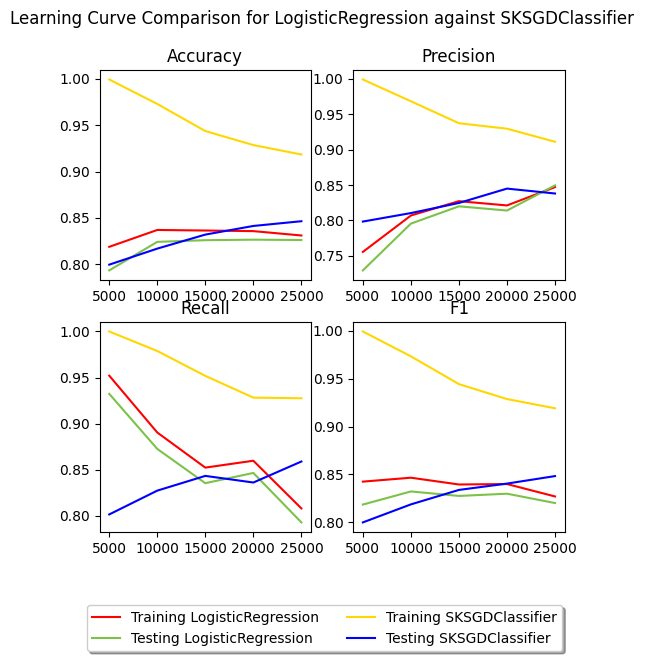

In [ ]:
plot = classification_plots_compare(data,linear_data)

### Selection of Hyperparameters
We use the following code to decide which hyperparameters are the best. In 3 arrays M, K, N, we have various values ​​with

M: number of vocabulary words

N: number of most frequent words to skip

K: number of rarest words to skip

We use the accuracy of the classifier on the development data to decide which combination of m, n, k is the best.

In [ ]:

from sklearn.model_selection import train_test_split

N = [50, 100, 200, 300]
K = [0, 20, 50, 80]
M = [500, 2000, 2500, 3000]

binary_vectorizer = CountVectorizer(binary=True)
minK = 0
minN = 0
minM = 0
maxAccuracy = -float('inf')

for m in M:
    for n in N:
        for k in K:
            (x_trainn, y_trainn), (x_testt, y_testt) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
            x_trainn, x_dev, y_trainn, y_dev = train_test_split(x_trainn, y_trainn, test_size=0.2)
            word_index = tf.keras.datasets.imdb.get_word_index()

            index2word = dict((i + 3, word) for (word, i) in word_index.items())
            index2word[0] = '[pad]'
            index2word[1] = '[bos]'
            index2word[2] = '[oov]'

            x_trainn = np.array([' '.join([index2word[idx] for idx in text]) for text in x_trainn])
            x_dev = np.array([' '.join([index2word[idx] for idx in text]) for text in x_dev])

            x_trainn_binary = binary_vectorizer.fit_transform(x_trainn)
            x_val_binary = binary_vectorizer.transform(x_dev)

            x_trainn_binary = np.array(x_trainn_binary.toarray())
            x_val_binary = np.array(x_val_binary.toarray())
            
            
            log.fit(x_trainn_binary, y_trainn)
            predicted_values = log.predict(x_val_binary)
            print("For M={}, N={} and K={}:".format(m, n, k))
            acc = accuracy_score(y_dev, predicted_values)
            print('Accuracy:', acc)
            if acc > maxAccuracy:
                maxAccuracy = acc
                minN = n
                minK = k
                minM = m

print("\nBest model parameters are:\n\tN: {}\n\tK:{} \n\tM: {}".format(minN, minK, minM))



For M=500, N=50 and K=0:
Accuracy: 0.6946
For M=500, N=50 and K=20:
Accuracy: 0.7124
For M=500, N=50 and K=50:
Accuracy: 0.6768
For M=500, N=50 and K=80:
Accuracy: 0.693
For M=500, N=100 and K=0:
Accuracy: 0.7254
For M=500, N=100 and K=20:
Accuracy: 0.7202
For M=500, N=100 and K=50:
Accuracy: 0.7168
For M=500, N=100 and K=80:
Accuracy: 0.6986
For M=500, N=200 and K=0:
Accuracy: 0.778
For M=500, N=200 and K=20:
Accuracy: 0.7732
For M=500, N=200 and K=50:
Accuracy: 0.7508
For M=500, N=200 and K=80:
Accuracy: 0.7424
For M=500, N=300 and K=0:
Accuracy: 0.7596
For M=500, N=300 and K=20:
Accuracy: 0.739
For M=500, N=300 and K=50:
Accuracy: 0.7112
For M=500, N=300 and K=80:
Accuracy: 0.7096
For M=2000, N=50 and K=0:
Accuracy: 0.7448
For M=2000, N=50 and K=20:
Accuracy: 0.7422
For M=2000, N=50 and K=50:
Accuracy: 0.749
For M=2000, N=50 and K=80:
Accuracy: 0.6962
For M=2000, N=100 and K=0:
Accuracy: 0.7874
For M=2000, N=100 and K=20:
Accuracy: 0.7384
For M=2000, N=100 and K=50:
Accuracy: 0.7678